In [2]:
import numpy as np
import pandas as pd
import re
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


### Cleaning letter transcript text

Before any NLP analysis, I performed a series of text pre-processing steps to remove punctuation and unnecessary annotations. I also used a couple of functions to get useful metrics like average sentence length and word count for each letter. I saved a separate dataframe "texts" that retains punctuation to be used in the sentiment analysis.

In [28]:
def remove_num(text):
    return re.sub('[0-9]','',text)
def remove_annotations(text):
    text = re.sub('\[.*?]','',text)
    return text.strip()
def remove_punc(text):
    return re.sub('[/.,\'"_’;:]',' ',text)
def remove_header(row):
    first_line = re.match('.*',row.clean_text)[0]
    if row.place in first_line:
        return re.sub(first_line,'',row.clean_text).strip()
    else: return row.clean_text
def count_words(text):
    return len([w for w in text.split() if len(w) > 1])
def count_sent(text):
    return len([s for s in sent_tokenize(text) if len(s) > 1])
def sent_length(text):
    sent_list = sent_tokenize(text)
    words_list = [s.split() for s in sent_list]
    return np.mean([len(t) for t in words_list])
def convert_date(date):
    try: date = pd.to_datetime(date)
    except: date = np.nan
    return date
def get_year(date):
    return int(re.search('[0-9]{4}',date)[0])

In [38]:
df = pd.read_pickle('data/letter_info.pkl')

In [39]:
df['clean_text'] = \
        df.transcript.apply(remove_num).apply(remove_annotations)

df['clean_text'] = df.apply(remove_header,axis=1)

df['word_count'] = df.clean_text.apply(count_words)

df['avg_sent_length'] = df.clean_text.apply(sent_length)

texts = df[['let_id','clean_text']]

df['clean_text'] = df.clean_text.apply(remove_punc)

df['year'] = df.date.apply(get_year)

texts['num_sent'] = texts.clean_text.apply(count_sent)

/Users/whitty/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [40]:
df.head(5)

,let_id,recipient,place,date,transcript,clean_text,word_count,avg_sent_length,year
0,001,Theo van Gogh,The Hague,"Sunday, 29 September 1872","The Hague, 29 September 1872.\nMy dear Theo,\n...",My dear Theo \nThanks for your letter I was g...,118,17.428571,1872
1,001a,Hendrik Verzijl,The Hague,"Saturday, 26 October 1872","The Hague, 26 Oct. 1872\nDear Sir,\nI regret t...",Dear Sir \nI regret that I have been unable to...,123,14.555556,1872
2,002,Theo van Gogh,The Hague,"Friday, 13 December 1872","The Hague, 13 December 1872.\nMy dear Theo,\nT...",My dear Theo \nThat was good news that I just ...,145,14.363636,1872
3,003,Theo van Gogh,The Hague,mid-January 1873,"The Hague, January 1873\nMy dear Theo,\nI hear...",My dear Theo \nI heard from home that you arri...,365,13.241379,1873
4,004,Theo van Gogh,The Hague,"Tuesday, 28 January 1873","The Hague, 28 Jan. 1873\nMy dear Theo,\nIt’s g...",My dear Theo \nIt s good that you answered me ...,409,13.838710,1873


In [41]:
texts.head(5)

,let_id,clean_text,num_sent
0,001,"My dear Theo,\nThanks for your letter, I was g...",7
1,001a,"Dear Sir,\nI regret that I have been unable to...",9
2,002,"My dear Theo,\nThat was good news that I just ...",11
3,003,"My dear Theo,\nI heard from home that you arri...",29
4,004,"My dear Theo,\nIt’s good that you answered me ...",31


I added a dummy variable column to define if the letter was written to his brother or not.

In [42]:
def to_brother(recipient):
    if 'Theo van Gogh' in recipient or 'Theodorus van Gogh' in recipient:
        return 1
    else:
        return 0

df['to_theo'] = df.recipient.apply(to_brother)

### Sentiment analysis

I performed sentiment analysis on each letter using Vader Sentiment Analysis. For each letter, I quantified the average sentiment (taking the average of the non-neutral sentences), the percent of sentences with a positive sentiment, and the percent of sentences with a negative sentiment.

In [47]:
analyzer = SentimentIntensityAnalyzer()
sentiment_info = []
sentences = []
for i,row in texts.iterrows():
    sen = sent_tokenize(row.clean_text)
    pos = 0
    neg = 0
    polarities = []
    for s in sen:
        pol = analyzer.polarity_scores(s)['compound'] # grab the compound score for each sentence 
        if pol < 0:
            neg += 1
            polarities.append(pol)
        elif pol > 0:
            pos += 1
            polarities.append(pol)
        if pol != 0: # saving a separate list of each sentence with its compound score
            sentences.append({'let_id': row.let_id, 'sentence':s, 'cmpd_score':pol})
    if len(polarities) != 0:
        avg = np.mean(polarities)
    else:
        avg = 0
    sentiment_info.append({'let_id': row.let_id, 
                       'perc_neg':neg/row.num_sent, 
                       'perc_pos':pos/row.num_sent, 
                       'avg_sentiment':avg, 
                       'num_sent':row.num_sent})

In [49]:
sentence_df = pd.DataFrame(sentences)

df = df.merge(pd.DataFrame(sentiment_info), how='outer', on='let_id')

df.drop(columns=['transcript','clean_text','date']).to_pickle('data/letters_with_NLP_results.pkl')

In [46]:
df.sample(3)

,let_id,recipient,place,date,transcript,clean_text,word_count,avg_sent_length,year,to_theo,avg_sentiment,num_sent,perc_neg,perc_pos
543,565,Theo van Gogh,Antwerp,"on or about Monday, 22 February 1886","My dear Theo,\nI tore up a letter that I wrote...",My dear Theo \nI tore up a letter that I wrote...,648,20.647059,1886,1,0.317268,34,0.147059,0.588235
21,021,Theo van Gogh,London,"Monday, 30 March 1874","London, 30 March 1874\nMy dear Theo,\nIn a let...",My dear Theo \nIn a letter from Pa and Ma I go...,186,15.153846,1874,1,0.555710,13,0.000000,0.769231
648,678,Willemien van Gogh,Arles,"Sunday, 9 and about Friday, 14 September 1888","My dear sister,\nYour letter gave me great ple...",My dear sister \nYour letter gave me great ple...,1320,18.350649,1888,0,0.381304,77,0.064935,0.610390


In [50]:
sentence_df.head()

,cmpd_score,let_id,sentence
0,0.8934,001,"My dear Theo,\nThanks for your letter, I was g..."
1,-0.4588,001,"I missed you the first few days, and it was st..."
2,0.6486,001,"We spent some pleasant days together, and actu..."
3,-0.6249,001,"What terrible weather, you must feel anxious o..."
4,-0.6486,001,Yesterday there were trotting races on the occ...


### Sentiment analysis EDA

Here are two letters side by side. You can see that the distribution of positive and negative sentences varies widely between the two. 

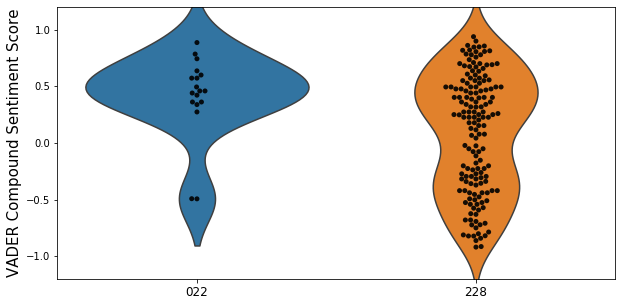

In [51]:
plt.close()
plt.figure(figsize=(10,5))
plt.ylim(-1.2,1.2)
sns.violinplot(x='let_id',y='cmpd_score',data=sentence_df[sentence_df['let_id'].isin(['022','228'])],inner=None)
sns.swarmplot(x='let_id', y='cmpd_score',data=sentence_df[sentence_df['let_id'].isin(['022','228'])], color='black', alpha=.9);
plt.xlabel('')
plt.xticks(size=12)
plt.ylabel('VADER Compound Sentiment Score',size=15);

When sorted according to the average sentiment, the letters with the most negative sentiment are the telegrams he wrote to his brother when his father had a stroke and died. The next most negative letter is #456, the letter he wrote to his brother after Miss Begemann poisoned herself.

In [57]:
df[['let_id','recipient','clean_text','avg_sentiment']].sort_values(by='avg_sentiment').head(4)

,let_id,recipient,clean_text,avg_sentiment
468,486,"Theo van Gogh, c/o Messrs Goupil, 19 boulevard...",sudden death come van gogh,-0.599400
470,488,"Theo van Gogh, c/o Messrs Goupil, rue Chaptal,...",our father fatal stroke van gogh,-0.542300
469,487,"Theo van Gogh, c/o 19 boulevard Montmartre, Paris",Our father fatal stroke come but it is over ...,-0.307100
438,456,Theo van Gogh,My dear Theo \nYou re quite right to ask why I...,-0.206609


If we look at the number of letters written each year, you can see that he wrote most in the years 1881-1884 and 1888. 1880 was when he moved further from his brother, which is likely why his writing increases. It could also be due to less surviving letters in the earlier years of correspondence.

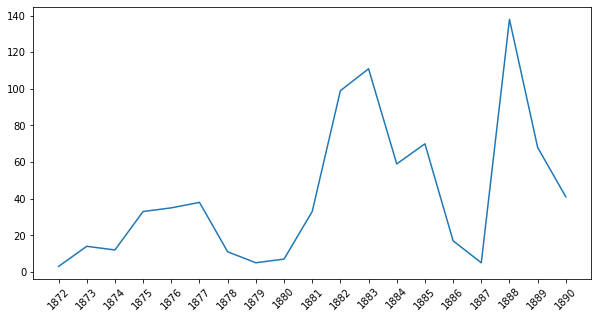

In [67]:
plt.figure(figsize=(10,5))
plt.plot(df.year.unique(),df.groupby('year').let_id.count())
plt.xticks(ticks=range(1872,1891), rotation=45);

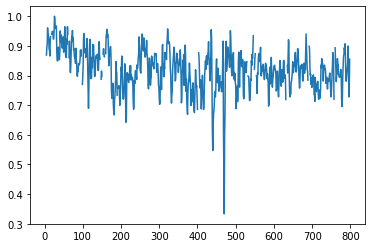

In [175]:
plt.plot(df.groupby('year').perc_pos.rolling(3).mean().values);

In [322]:
df.sort_values(by='let_id').perc_neg.rolling(20).mean()[700:750]

700    0.169847
701    0.168569
702    0.172281
703    0.183092
704    0.190368
705    0.197244
706    0.202276
707    0.206443
708    0.200619
709    0.206064
710    0.209241
711    0.220779
712    0.226613
713    0.227545
714    0.228773
715    0.229738
716    0.237768
717    0.236379
718    0.237945
719    0.239086
720    0.244306
721    0.245190
722    0.245524
723    0.239400
724    0.240512
725    0.227428
726    0.223381
727    0.220881
728    0.222235
729    0.220082
730    0.214051
731    0.210652
732    0.208857
733    0.205274
734    0.203835
735    0.203974
736    0.199680
737    0.194076
738    0.195591
739    0.196502
740    0.189359
741    0.189200
742    0.191230
743    0.196542
744    0.195917
745    0.199743
746    0.201827
747    0.204327
748    0.209446
749    0.209854
Name: perc_neg, dtype: float64

In [372]:
df.drop(632).sort_values(by='let_id').perc_neg.rolling(20).mean().reset_index().to_csv('neg_over_time.csv')

In [370]:
df.drop(632).loc[630:,:]

,let_id,recipient,place,date,transcript,clean_text,word_count,avg_sent_length,year,to_theo,time_frame,avg_sentiment,perc_neg,perc_pos,perc_neut,num_sent
630,659,Theo van Gogh,Arles,"on or about Sunday, 12 August 1888","My dear Theo,\nI have to thank you for quite a...",My dear Theo \nI have to thank you for quite a...,912,21.727273,1888,1,late,0.245919,0.295455,0.545455,0.159091,44
631,660,Theo van Gogh,Arles,"on or about Monday, 13 August 1888","My dear Theo,\nYesterday I spent the evening w...",My dear Theo \nYesterday I spent the evening w...,1560,18.954023,1888,1,late,0.092706,0.321839,0.390805,0.287356,87
633,662,Theo van Gogh,Arles,"Wednesday, 15 August 1888",My dear Theo\nYou’ll have received my telegram...,My dear Theo\nYou ll have received my telegram...,684,21.909091,1888,1,late,0.411710,0.090909,0.545455,0.363636,33
634,663,Theo van Gogh,Arles,"Saturday, 18 August 1888","My dear Theo,\nYou’ll shortly make the acquain...",My dear Theo \nYou ll shortly make the acquain...,1035,20.905660,1888,1,late,0.246585,0.226415,0.509434,0.264151,53
635,664,Theo van Gogh,Arles,"Sunday, 19 or Monday, 20 August 1888",My dear Theo\nMany thanks for your kind letter...,My dear Theo\nMany thanks for your kind letter...,973,23.340909,1888,1,late,0.316462,0.181818,0.545455,0.272727,44
636,665,Emile Bernard,Arles,"on or about Tuesday, 21 August 1888","My dear Bernard,\nI want to do figures, figure...",My dear Bernard \nI want to do figures figure...,466,16.800000,1888,0,late,0.223080,0.166667,0.500000,0.333333,30
637,666,Theo van Gogh,Arles,"Tuesday, 21 or Wednesday, 22 August 1888","My dear Theo,\nI’m writing to you in great has...",My dear Theo \nI m writing to you in great has...,507,16.937500,1888,1,late,0.425661,0.031250,0.531250,0.437500,32
638,667,Willemien van Gogh,Arles,"Tuesday, 21 or Wednesday, 22 August 1888","My dear sister,\nI’m dropping you a line in ha...",My dear sister \nI m dropping you a line in ha...,448,18.960000,1888,0,late,0.526515,0.040000,0.480000,0.480000,25
639,668,Theo van Gogh,Arles,"Thursday, 23 or Friday, 24 August 1888","My dear Theo,\nWould you ask Tasset his opinio...",My dear Theo \nWould you ask Tasset his opinio...,658,17.300000,1888,1,late,0.167338,0.200000,0.400000,0.400000,40
640,669,Theo van Gogh,Arles,"on or about Sunday, 26 August 1888","My dear Theo,\nMany thanks for your letter and...",My dear Theo \nMany thanks for your letter and...,695,21.529412,1888,1,late,0.090338,0.352941,0.352941,0.294118,34


In [371]:
df.drop(632).sort_values(by='let_id').perc_neg.rolling(20).mean()[630:]

630    0.198765
631    0.200887
633    0.192932
634    0.196845
635    0.196845
636    0.196024
637    0.193420
638    0.180268
639    0.178363
640    0.187677
641    0.191983
642    0.190792
643    0.200459
644    0.198103
645    0.196896
646    0.210731
647    0.206501
648    0.196704
649    0.202323
650    0.204055
651    0.193828
652    0.186307
653    0.193554
654    0.186885
655    0.181365
656    0.183133
657    0.192285
658    0.197618
659    0.196547
660    0.186043
         ...   
769    0.180279
770    0.179641
771    0.179641
772    0.181004
773    0.184641
774    0.189594
775    0.188810
776    0.191935
777    0.189705
778    0.200639
779    0.202776
780    0.203779
781    0.203021
782    0.196146
783    0.190041
784    0.189077
785    0.184531
786    0.182524
787    0.184371
788    0.192149
789    0.186091
790    0.184424
791    0.188537
792    0.180662
793    0.177571
794    0.175231
795    0.181448
796    0.187995
797    0.168430
798    0.157496
Name: perc_neg, Length: 

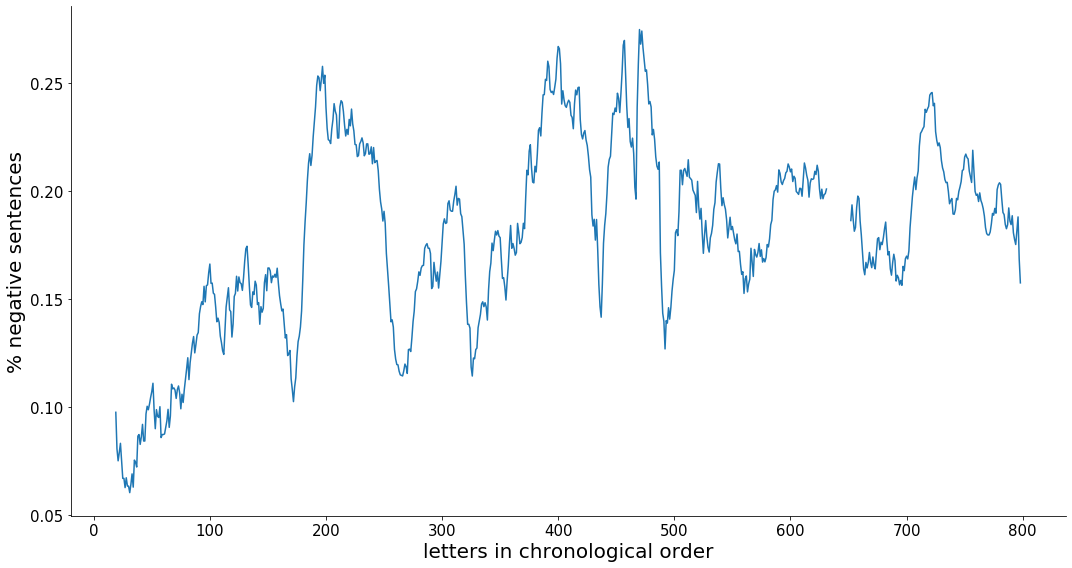

In [348]:
plt.figure(figsize=(15,8))
plt.plot(df.sort_values(by='let_id').perc_neg.rolling(20).mean())
plt.ylabel('% negative sentences',fontsize=20)
plt.xlabel('letters in chronological order',rotation=0,fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.tight_layout()
sns.despine();
plt.savefig('neg_over_time.png')
# around 200: letter 194 - gets kicked out by his father
# 228: fighting with his brother over Sien 
# 456 margot attempts suicide
# 486: father dies 